# Data Analysis

## Currently, this uses a .csv file with the numDates being in decimal

In [29]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import glob
import os
import numpy.ma as ma
import math
from netCDF4 import stringtochar

### Loading csv file

In [30]:
meta_data = pd.read_csv('https://raw.githubusercontent.com/mmaliu97/CW3E_Avalanche_AR/main/data/snotel_meta_data.csv')
avalanche_data = pd.read_csv('https://raw.githubusercontent.com/mmaliu97/CW3E_Avalanche_AR/main/data/avalanche_coords_datenum.csv')


In [31]:
meta_data_dict = dict(tuple(meta_data.groupby('state')))
avalanche_data_dict = dict(tuple(avalanche_data.groupby('state')))


## Map plotting of sites and avalanches

In [32]:
from IPython.display import IFrame
documentation = IFrame(src='https://scitools.org.uk/cartopy/docs/latest/#', width=1000, height=500)
display(documentation)

In [33]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import cartopy.mpl.geoaxes
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
import numpy as np
from vega_datasets import data as vds

### Plotting Alaska

In [34]:
lats = avalanche_data_dict['AK']['lat'].tolist()
lons = avalanche_data_dict['AK']['lon'].tolist()
lons[0]

-144.35

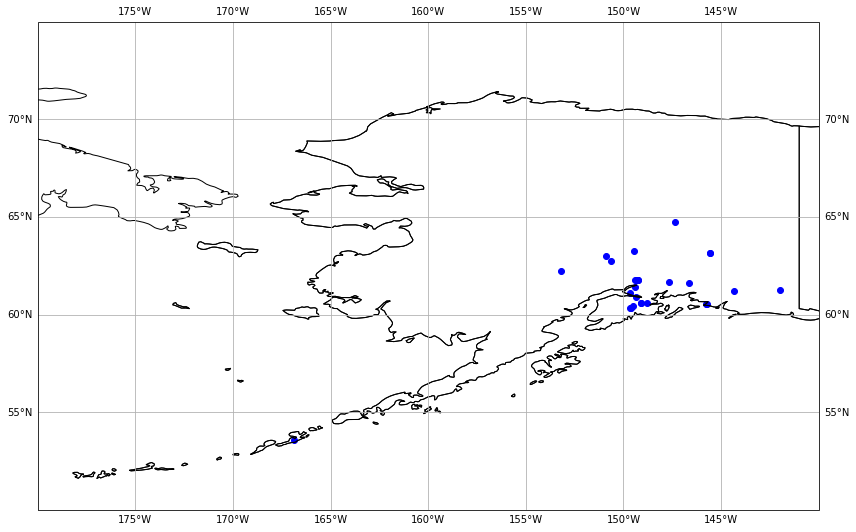

In [38]:
lats = avalanche_data_dict['AK']['lat'].tolist()
lons = avalanche_data_dict['AK']['lon'].tolist()

fig = plt.figure(figsize=(14, 14))
m6 = plt.axes(projection=ccrs.PlateCarree())
# (x0, x1, y0, y1)
m6.set_extent([-180, -140, 50, 75], ccrs.PlateCarree())         
m6.add_feature(cfeature.STATES)
m6.coastlines()
grid_lines = m6.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER

for i in range(len(lats)):
    m6.scatter(lons[i], lats[i], color='blue', transform=ccrs.PlateCarree())


### Plotting Western US

In [27]:
avalanch_data_west_US = avalanche_data.loc[avalanche_data['state'] != 'AK']

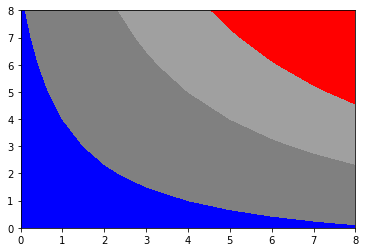

In [50]:
x = np.arange(1, 10)
y = x.reshape(-1, 1)
h = x * y

cs = plt.contourf(h, levels=[10, 30, 50],
    colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')
cs.cmap.set_over('red')
cs.cmap.set_under('blue')
cs.changed()

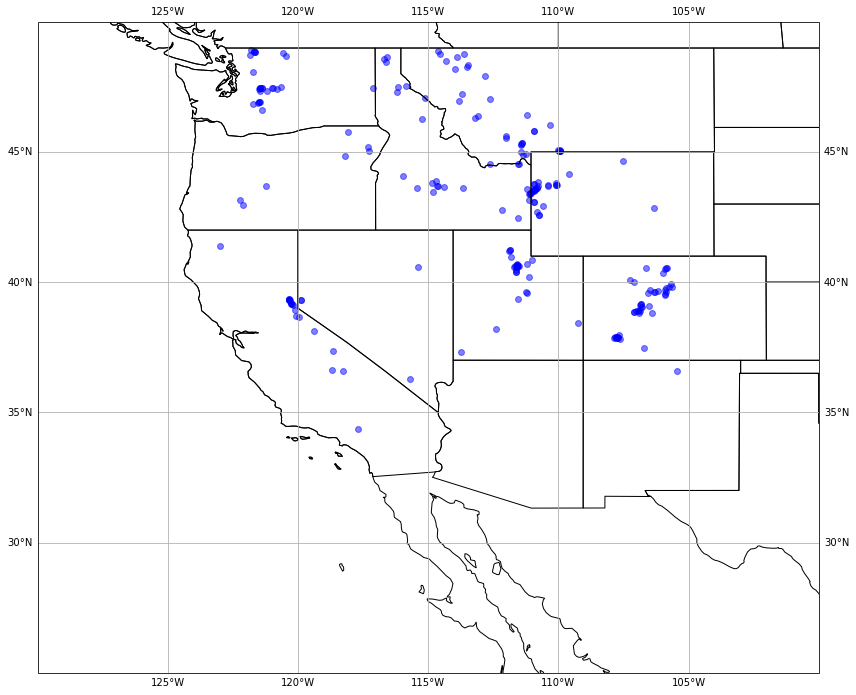

In [51]:
lats = avalanch_data_west_US['lat'].tolist()
lons = avalanch_data_west_US['lon'].tolist()

fig = plt.figure(figsize=(14, 14))
m6 = plt.axes(projection=ccrs.PlateCarree())
# (x0, x1, y0, y1)
# US SIZE: -130, -60, 20, 55
m6.set_extent([-130, -100, 25, 50], ccrs.PlateCarree())         
m6.add_feature(cfeature.STATES)
m6.coastlines()
#m6.stock_img()
grid_lines = m6.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER

for i in range(len(lats)):
    m6.scatter(lons[i], lats[i], color='blue', s=35, alpha=0.5, transform=ccrs.PlateCarree())


## Plotting the weather patterns 6 days before and 1 day after the avalanche

### First seperate the data according to states

In [10]:
avalanche_weather = avalanche_weather[::-1].reset_index(drop = True)

In [11]:
avalanche_weather_dict = dict(tuple(avalanche_weather.groupby('State')))

## Making a function that sieves dataframes into 8 days

### Note that day 1 is always avalanche day

In [12]:
alaska_weather = avalanche_weather_dict['AK'].reset_index(drop = True)

var_cols = ['SWE', 'Precipitation', 'Cumulative_Precipitation', 'Max_Temp', 'Min_Temp']
day_cols = ['day0', 'day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7']


,State,Latitude,Longitude,Date,SWE,Precipitation,Cumulative_Precipitation,Max_Temp,Min_Temp
0,AK,-149.67,61.11,16762,51.0,0,112,0.9,-8.8
1,AK,-149.67,61.11,16761,51.0,0,112,-2.9,-15.8
2,AK,-149.67,61.11,16760,41.0,13,99,-0.3,-10.4
3,AK,-149.67,61.11,16759,33.0,8,91,2.1,-3.9
4,AK,-149.67,61.11,16758,33.0,5,86,0.1,-14.8
...,...,...,...,...,...,...,...,...,...
699,AK,-149.09,60.96,16759,25.0,3,239,2.4,-1.1
700,AK,-149.09,60.96,16758,25.0,0,239,1.6,-10.1
701,AK,-149.09,60.96,16757,25.0,3,236,-9.3,-16.6
702,AK,-149.09,60.96,16756,25.0,0,236,-13.0,-17.1


#### This function generates a dictionary for the weather in the state

In [40]:
def small_df(df):
    day0 = df.loc[0:len(alaska_weather)-7:8].reset_index(drop = True)
    day1 = df.loc[1:len(alaska_weather)-6:8].reset_index(drop = True)
    day2 = df.loc[2:len(alaska_weather)-5:8].reset_index(drop = True)
    day3 = df.loc[3:len(alaska_weather)-4:8].reset_index(drop = True)
    day4 = df.loc[4:len(alaska_weather)-3:8].reset_index(drop = True)
    day5 = df.loc[5:len(alaska_weather)-2:8].reset_index(drop = True)
    day6 = df.loc[6:len(alaska_weather)-1:8].reset_index(drop = True)
    day7 = df.loc[7:len(alaska_weather):8].reset_index(drop = True)
    
    small_df_dict = {'day0': day0, 'day1': day1, 'day2': day2, 'day3': day3, 'day4': day4, 'day5': day5, 
                     'day6': day6, 'day7': day7}
    return small_df_dict

#### Making the dictionary for alaskan weather

In [41]:
alaska_dict = small_df(alaska_weather)

## Making a function to determine average weather variable for a particular day

In [57]:
def weather_avg(variable,df):  
    count = 0
    factor = 0
    for i in range(len(df)):
        if pd.isna(df[variable][i]) == True:
            pass
        else:
            count = count + 1
            factor = factor + df[variable][i]
    # round to 3 dp
    average = np.round(factor/count,3)
    return average

In [58]:
weather_avg(var_cols[4],alaska_dict['day4'])

-15.265

In [56]:
var_cols[4]

'Min_Temp'

## Time to plot!

### Start with AK - SWE

SWE


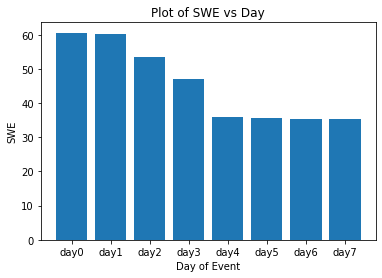

Precipitation


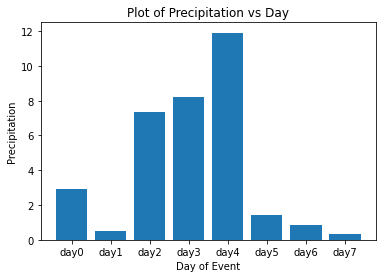

Cumulative_Precipitation


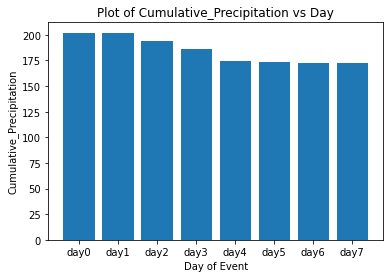

Max_Temp


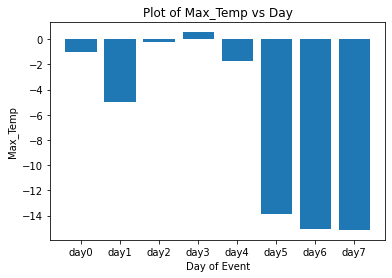

Min_Temp


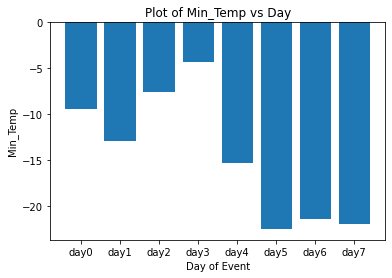

In [63]:
for k in range(len(var_cols)):
    var = var_cols[k]
    print(var)
    y_val = []
    for n in range(len(day_cols)):
        day = day_cols[n]
        df = alaska_dict[day]
        average = weather_avg(var,df)
        y_val.append(average)
        
    plt.bar(day_cols,y_val)
    plt.title('Plot of '+var+' vs Day')
    plt.xlabel('Day of Event')
    plt.ylabel(var)
    plt.show()

In [48]:
day_cols

['day0', 'day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7']